# 使用LSTM对IMDB数据进行文本分类

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras.datasets import imdb
from keras.layers import Embedding, Dense, LSTM
import jieba

## 读取数据

In [2]:
top_words = 10000
(X_train, Y_train), (X_test, Y_test) = imdb.load_data(num_words=top_words)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
D:\programs\Anaconda3\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
D:\programs\Anaconda3\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specif

读取数据，`num_words`表示取最常出现的单词个数。imdb数据集一共有88584个单词，意味着只取其中最常见的10000个：

In [3]:
word_dict = imdb.get_word_index()

In [4]:
len(word_dict)

88584

此时读取的都是已经处理好的数据，每一个单词对应着一个数字的索引，比如：

In [5]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

其中，0、1、2三个数字有特殊意义，分别代表填充、序列开始以及未知单词。如果想根据索引返回单词，可以这样做：

In [6]:
# 首先构造{索引：值}的字典
reverse_word_index = dict([(value, key) for (key, value) in word_dict.items()])

In [20]:
decode_view = ' '.join(
    [reverse_word_index.get(i - 3, '?') for i in X_train[0]])
decode_view

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

`i-3`是因为0、1、2是保留值，`reverse_word_index`字典的索引又是从1开始，`load_data`方法读取出来的整数序列的索引是从4开始，两者索引值相差3才能匹配上，比如第一行评论的第二个单词`this`，其索引是：

In [31]:
X_train[0][1]

14

所以`get_word_index`方法返回的单词和索引的字典，索引需要减去3：

In [32]:
word_dict['this']

11

In [34]:
reverse_word_index[11]

'this'

此时，每条评论的单词数目不一致，比如第一条评论有218个单词，第二条评论189个单词，如果看成向量，需要所有向量长度一致，才能作为神经网络的输入。

In [40]:
len(X_train[0])

218

In [41]:
len(X_train[1])

189

因此，对评论构成的列表进行填充，设置列表长度为500，多出的截断，不足的补零。

In [110]:
# truncate and pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

此时所有评论长度一致，可以作为输入：

In [45]:
len(X_train[0])

500

也可以采用独热编码来使向量长度一致，原理如下：

In [55]:
def one_hot(data, dimension=10000):
    results = np.zeros((len(data), dimension))
    for i, seq in enumerate(data):
        results[i, seq] = 1.
    return results

one_hot([[1, 5], [2, 3, 4]], dimension=6)

array([[0., 1., 0., 0., 0., 1.],
       [0., 0., 1., 1., 1., 0.]])

## 训练模型

首先是Embedding词嵌入层，这一层的作用是将高维的向量压缩到低维，高维的稀疏的整数向量用低维的紧凑的浮点数向量表示，最少接收2个参数分别是标记的个数，和嵌入的维度。

Embedding层返回的是形状为(samples, sequence_length, embedding_dimensionality)的三维浮点数张量，因为RNN层或一维卷积层处理的是三维张量而不是二维的，其中第二个`sequence_length`就相当于RNN或者LSTM的时间戳。

In [124]:
# create the model
embedding_vecor_length = 64
model = Sequential()

# top_words即前面选取的最常用的10000个单词，压缩到64维，每一行向量的长度是500
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
# LSTM输出为32维，其它参数采用keras默认值
model.add(LSTM(32))
# 最后要添加一个dense层对应着输出，因为输出为2分类，只存在着0、1两个值，因此最后输出的维度为1
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 500, 64)           640000    
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 652,449
Trainable params: 652,449
Non-trainable params: 0
_________________________________________________________________
None


`batch_size`指每次使用64个，而不是全部的样本进行训练，一次`epochs`指全部的样本训练完。

- [What is batch size in neural network?](https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network)

In [125]:
history = model.fit(X_train, Y_train, epochs=8, batch_size=64, validation_split=0.2)

Epoch 1/8
313/313 [==============================] - 47s 149ms/step - loss: 0.4760 - accuracy: 0.7707 - val_loss: 0.3451 - val_accuracy: 0.8538
Epoch 2/8
313/313 [==============================] - 44s 142ms/step - loss: 0.2665 - accuracy: 0.8971 - val_loss: 0.3194 - val_accuracy: 0.8634
Epoch 3/8
313/313 [==============================] - 44s 141ms/step - loss: 0.1823 - accuracy: 0.9337 - val_loss: 0.3230 - val_accuracy: 0.8826
Epoch 4/8
313/313 [==============================] - 43s 136ms/step - loss: 0.1347 - accuracy: 0.9552 - val_loss: 0.4007 - val_accuracy: 0.8350
Epoch 5/8
313/313 [==============================] - 42s 133ms/step - loss: 0.1642 - accuracy: 0.9384 - val_loss: 0.3753 - val_accuracy: 0.8542
Epoch 6/8
313/313 [==============================] - 41s 132ms/step - loss: 0.0934 - accuracy: 0.9681 - val_loss: 0.4144 - val_accuracy: 0.8784
Epoch 7/8
313/313 [==============================] - 41s 132ms/step - loss: 0.0606 - accuracy: 0.9808 - val_loss: 0.4669 - val_accuracy:

返回的`history`对象包含每一次训练的损失和准确度数据：

In [130]:
hist_dict = history.history
hist_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

可以作图查看损失和准确度的变化：

In [161]:
%%writefile 'keras_utils.py'
def plot_history(hist_dict, figsize=(10, 4)):
    fig = plt.figure(figsize=(10, 4))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    loss_values = hist_dict['loss']
    val_loss_values = hist_dict['val_loss']
    epochs = range(1, len(loss_values) + 1)  # 获取横坐标
    ax1.plot(epochs, loss_values, ':bo', label='Training loss')
    ax1.plot(epochs, val_loss_values, ':go', label='Validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    acc = hist_dict['accuracy']
    val_acc = hist_dict['val_accuracy']
    ax2.plot(epochs, acc, ':bo', label='Training acc')
    ax2.plot(epochs, val_acc, ':go', label='Validation acc')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

Writing keras_utils.py


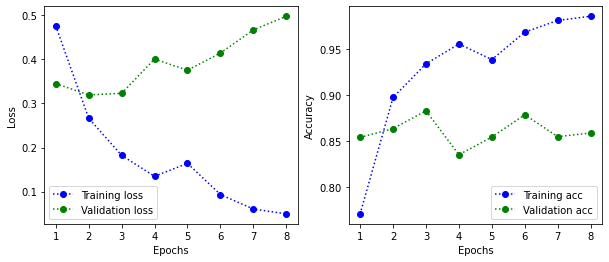

In [149]:
plot_history(hist_dict)

可见，模型基本上从第三轮开始就过拟合了。因此，需要对模型进行正则化，LSTM的有两个参数`dropout`和`recurrent_dropout`，分别对应着循环层每一层输入和循环的`dropout`。
- [**dropout** 和 **recurrent_dropout** 的区别](https://stackoverflow.com/questions/44924690/keras-the-difference-between-lstm-dropout-and-lstm-recurrent-dropout)

添加这两个参数后再进行测试：

In [152]:
# create the model
embedding_vecor_length = 64
model = Sequential()

# top_words即前面选取的最常用的10000个单词，压缩到64维，每一行向量的长度是500
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
# LSTM输出为32维，其它参数采用keras默认值
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
# 最后要添加一个dense层对应着输出，因为输出为2分类，只存在着0、1两个值，因此最后输出的维度为1
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
313/313 [==============================] - 112s 358ms/step - loss: 0.4599 - accuracy: 0.7829 - val_loss: 0.3098 - val_accuracy: 0.8712
Epoch 2/5
313/313 [==============================] - 114s 366ms/step - loss: 0.2541 - accuracy: 0.9033 - val_loss: 0.3044 - val_accuracy: 0.8840
Epoch 3/5
313/313 [==============================] - 113s 360ms/step - loss: 0.1905 - accuracy: 0.9318 - val_loss: 0.3305 - val_accuracy: 0.8556
Epoch 4/5
313/313 [==============================] - 113s 360ms/step - loss: 0.1847 - accuracy: 0.9297 - val_loss: 0.3273 - val_accuracy: 0.8750
Epoch 5/5
313/313 [==============================] - 112s 359ms/step - loss: 0.1231 - accuracy: 0.9562 - val_loss: 0.3960 - val_accuracy: 0.8734


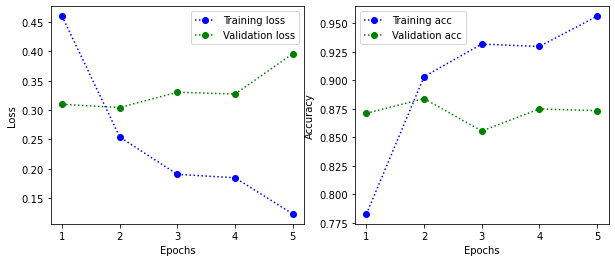

In [153]:
hist_dict = history.history
plot_history(hist_dict)

即使是使用了`dropout`，基本上在第三轮就出现了过拟合，因此训练2轮基本上就可以得到最终的结果。

## 评估模型

可以调用模型的`evaluate`方法在验证集上进行评估：

In [154]:
# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: {:.2f}%".format(scores[1] * 100))

Accuracy: 85.92%


## 保存模型

可以直接在模型上调用`save`方法保存模型：

In [155]:
model.save('imdb_lstm.h5')

可以通过`load_model`来读取模型：

In [159]:
model = load_model('imdb_lstm.h5')
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 500, 64)           640000    
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 652,449
Trainable params: 652,449
Non-trainable params: 0
_________________________________________________________________


除此之外，还可以保存为json或者yaml格式。
- [How to Save and Load Your Keras Deep Learning Model](https://machinelearningmastery.com/save-load-keras-deep-learning-models/)